# **BIOINFORMATICS** PROJECT - by Silvio Valli

In [2]:
from Bio import SeqIO, Entrez, AlignIO, Phylo
from Bio.SeqRecord import SeqRecord
from Bio.Align import substitution_matrices as sm, PairwiseAligner
from Bio.Phylo.Applications import PhymlCommandline
import csv
import numpy as np
from matplotlib import pyplot as plt
import copy
import subprocess
import os
Entrez.email='s.valli2@studenti.unipi.it'

C:\Users\Silvio\anaconda3\Lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


## STEP 1

Get gene and genomes ids from the csv files and get the sequences from the NCBI server

In [61]:
def getGene(gene_file, low_inter, up_inter):
    #get the ids from the csv file and store only the first one
    with open(gene_file, 'r') as f:
        ids = list(csv.reader(f, delimiter=','))
    gene_id=ids[0]
    print('Reading from file success!')

    #search the id on the "nucleotide" database and retrieve the file about the gene in fasta format
    try:
        #retrieve the gene by the id
        handle=Entrez.efetch(db='nucleotide', id=gene_id, rettype='fasta', retmode='text')
        #store the content in fasta format
        gene=SeqIO.read(handle, format='fasta')
        handle.close()
        print('Gene uploading success!')
        #return only the piece of the seq delimited by the "lower_inter" and "up_inter" (region where we know the gene of our interest is located)
        return gene.seq[low_inter:up_inter]
    except Exception as exc:
        print(f'"{exc}" error --> Gene uploading failed!')

In [63]:
#Get the id of the gene from a 'csv' file
gene_seq=getGene('SARS-CoV-2_genome.csv',21563,25384)

Reading from file success!
Gene uploading success!


**Double Check** --> check if the length of the sequence we have identified is the same as the gene of our interest

In [66]:
print(len(gene_seq))

3821


In [72]:
#Get the ids of the genomes from a 'csv' file
def readGenomes(genomes_file):
    with open(genomes_file, 'r') as f:
        genomes=[genome[0] for genome in list(csv.reader(f, delimiter=','))]
    return genomes

In [74]:
genomes_ids=readGenomes('SARS-CoV-2_variants.csv')
genomes_ids

['PP791391.1',
 'PQ968032.1',
 'BS016399.1',
 'BS016085.1',
 'PV002179.1',
 'PQ964503.1',
 'PV002009.1',
 'PV002455.1',
 'PV002221.1',
 'PV002147.1']

In [76]:
#from the ids of the genomes get their sequences
def getGenomes(genomes_ids):
    genomes=[]
    try: 
        for id in genomes_ids:
            #retrieve the genome by id
            handle=Entrez.efetch(db='nucleotide', id=id, rettype='fasta', retmode='text')
            #store the fasta format of the genomes 
            genomes.append(SeqIO.read(handle, format='fasta'))
            handle.close()
        print('Genomes uploading success!')
        return genomes
    except Exception as exc:
        print(f'"{exc}" error --> Genomes uploading failed!')

In [78]:
genomes=getGenomes(genomes_ids)

Genomes uploading success!


**Double check** --> check if the length of the each genomes is the same as the ones of our interest

In [81]:
for genome in genomes:
    print(len(genome.seq))

29706
29753
29811
29763
29803
29752
29730
29763
29741
29767


In [83]:
#Rename the names of the genomes objects adding element from a list of name
def getGenomes_names(genomes,genomes_names):
    try:
        i=0
        for genome in genomes:
            #Add "-" and a name to every genome name
            genome.name=genome.name+ '-' +genomes_names[i]
            i+=1
        print('Genomes named correctly!')
    except Exception as exc:
        print(f'"{exc}" has occur') 

In [85]:
getGenomes_names(genomes, genomes_names=['Omicron', 'Omicron', 'Omicron', 'Alpha', 'Zeta', 'Beta', 'Gamma', 'Delta', 'Lambda', 'Kappa'])

Genomes named correctly!


## STEP 2

Find the gene within the genomes

In [87]:
#Function to create a graph of the result of the "findGene" function
def findGeneGraphs(overall_scores, genomes, protein):
    #initialize the graph structure; in this case 2*5 subplots
    fig, axes = plt.subplots(2, 5, sharey=True, figsize=(15, 6))
    axes = axes.flatten()
    for i, y in enumerate(overall_scores):
        x = range(len(y))  # Use indices as x-values
        axes[i].plot(x, y)
        axes[i].set_title(f"{genomes[i].name}")
    fig.text(0.5, 0.04, "GENOME intervals of 500bp", ha="center", fontsize=14)  # Shared X-axis label
    fig.text(0.04, 0.5, "SCORES", va="center", rotation="vertical", fontsize=14)  # Shared Y-axis label
    fig.suptitle(f"{protein} Scores Across Genomes", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.show()

In [89]:
#Find the gene within each genomes
def findGene(gene_seq, genomes,protein, genomeWindow=500,geneWindow=100,padding=200):
    #initialize the Aligner and set the "mode", "gap_score" and the "substitution_matrix" we are going to use
    aligner=PairwiseAligner()
    aligner.mode='local'
    aligner.gap_score=-10
    aligner.substitution_matrix=sm.load("BLASTN") #Ideal for local alignments between nucleotides
    scores=[]
    overall_scores=[]
    geneInGenomes=[]
    start=0
    i=0
    
    #iterate over the genomes
    for genome in genomes:
        #Continue until we have visited all the genome's sequence
        while start<len(genome.seq):
            #store the score for each alignment 
            scores.append(aligner.score(gene_seq[:geneWindow],genome.seq[start:start+genomeWindow]))
            #update the "start" to move the window where to search the gene 
            start=start+genomeWindow
            
        #barplot the scores obtained    
        plt.bar(range(len(scores)),scores, label=genome.name)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

        #Find the window in the genome seq where we have the higher score for the alignment --> where the gene is in the genome
        start=np.argmax(scores)*genomeWindow 
        end=start+len(gene_seq)
        #"padding" handle the inaccuracy we could have while discretizing the search in windows of 500bp each
        start=max(0,start-padding)
        end=end+padding
        
        print(f'"{genome.name}" genome, found between: {start} - {end} of length: {end-start}')

        #align the gene_seq and the piece of the genomes where we had the highest score
        aln=aligner.align(genome.seq[start:end],gene_seq)
        #from the best alignment we have obtained store the start index and the end index of the alignment
        s=start+aln[0].aligned[0][0][0]
        e=start+aln[0].aligned[0][-1][1]
        geneInGenomes.append(genome.seq[s:e])
        #double check the length of the best alignment found with the length of the gene
        print('found a gene of length:',len(geneInGenomes[i]))
        
        i+=1
        overall_scores.append(copy.deepcopy(scores))
        scores.clear()
        start=0
    #plot the scores obtained while searching the gene within the genomes sequence; this is done for all the genomes.     
    findGeneGraphs(overall_scores, genomes, protein)
    return geneInGenomes

"PP791391.1-Omicron" genome, found between: 20800 - 25021 of length: 4221
found a gene of length: 3545
"PQ968032.1-Omicron" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3806
"BS016399.1-Omicron" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3809
"BS016085.1-Alpha" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3812
"PV002179.1-Zeta" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3821
"PQ964503.1-Beta" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3812
"PV002009.1-Gamma" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3821
"PV002455.1-Delta" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3815
"PV002221.1-Lambda" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3800
"PV002147.1-Kappa" genome, found between: 21300 - 25521 of length: 4221
found a gene o

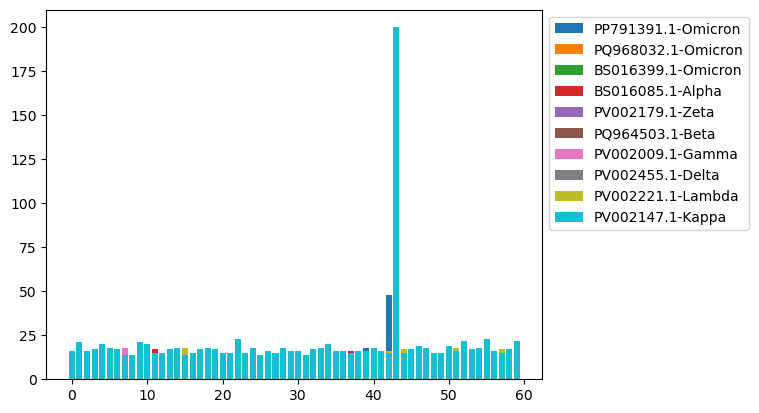

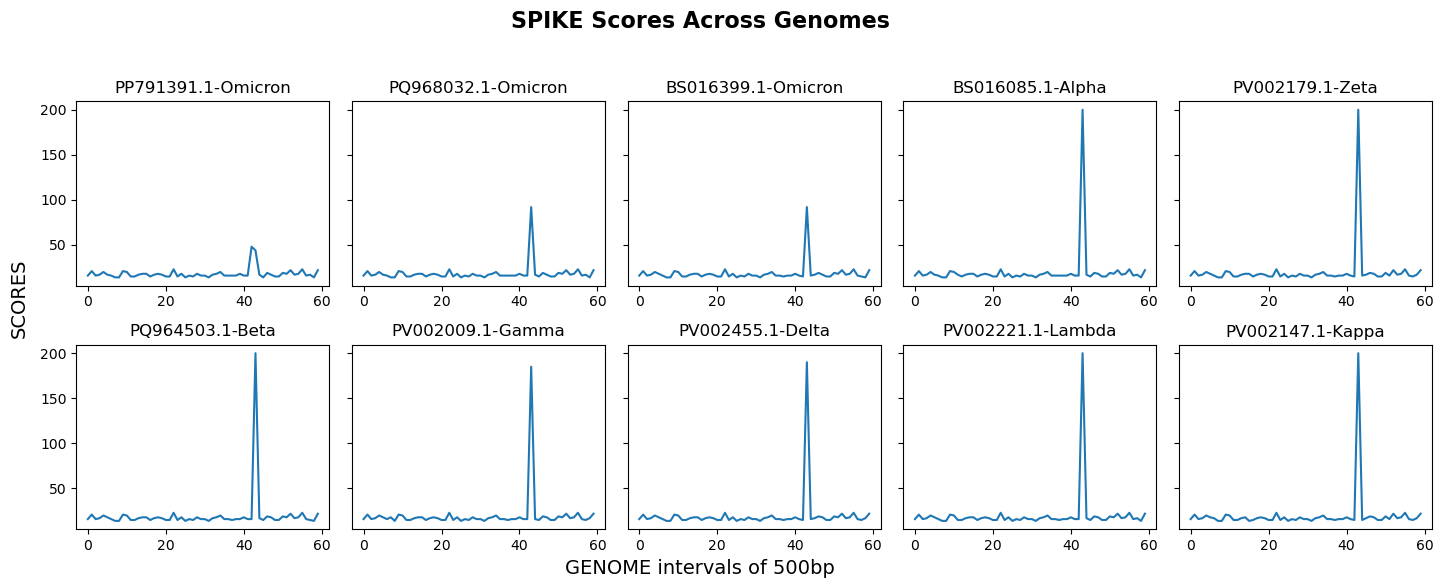

In [91]:
geneInGenomes=findGene(gene_seq, genomes, protein='SPIKE')

**Double check** --> check for every genomes the length of the best local alignment found with the gene

In [96]:
for seq in geneInGenomes:
    print(len(seq))

3545
3806
3809
3812
3821
3812
3821
3815
3800
3818


In [20]:
print(geneInGenomes)

[Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTCATGCCGC...CTC'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTCATGCCGC...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTCATGCCAC...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTA...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTA...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTA...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTA...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTTTGTTAATCTTA...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTA...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTA...TAA')]


## STEP 3

Perform a multiple sequence alignment

In [100]:
#Slight useless function to define the basename of the files
def fileName(name):
    file_name= name
    return file_name

In [102]:
file_name=fileName('local_spike')

In [104]:
#Check whether in the working directory we already have files with the same name and if true remove them
def checkDuplicates(file_name):
    if os.path.exists(file_name +'.fasta'):
        os.remove(file_name + '.fasta')
    if os.path.exists(file_name +'.aln'):
        os.remove(file_name + '.aln')
    if os.path.exists(file_name +'.phylip'):
        os.remove(file_name + '.phylip')
    if os.path.exists(file_name +'.phylip_phyml_stats'):
        os.remove(file_name + '.phylip_phyml_stats')
    if os.path.exists(file_name +'.phylip_phyml_tree'):
        os.remove(file_name + '.phylip_phyml_tree')

In [110]:
#function for the multiple sequence local alignment
def local_msa(geneInGenomes, genomes, file_name):
    #we want to keep the SeqIO fasta object and we do not want to modify the original objects --> create a copy
    m_genomes=copy.deepcopy(genomes)
    i=0

    #replacing the entire dna sequences with the piece of the sequence that has the highest alignment score
    for genome in m_genomes:
        genome.seq=geneInGenomes[i]
        i+=1
    #define fasta file and remove duplicates
    local_fasta=file_name +'.fasta'
    checkDuplicates(file_name)

    #write the new genomes objects into a new file using fasta format
    with open(local_fasta, 'w') as f:
        SeqIO.write(m_genomes, f, format='fasta')

    #Run the Multiple Sequence Alignment (MSA) and save the result into a ".clustal" file
    #We did not use the Biopython module to perform multiple sequence alignment (clustal) but the “subprocess” module to run the program previously installed on the PC.
    try:
        clustalw_exe = r"C:\Program Files (x86)\ClustalW2\clustalw2.exe" 
        input_file = local_fasta
        command = [clustalw_exe, "-INFILE=" + input_file]
        result = subprocess.run(command, capture_output=True, text=True)
        if result.returncode == 0:
            print("ClustalW (msa) success!")
    except Exception as exc:
        print(f"Error running ClustalW, {exc} error")
        print(result.stderr) 

In [112]:
local_msa(geneInGenomes, genomes,file_name)

ClustalW (msa) success!


## STEP 4

Create the phylogenetic tree

In [114]:
#Function for the phylogenetic tree generation
def tree_generation(file_name, protein):
    try:
        #we need to convert the result of the MSA into a ".phylip" format
        msa=AlignIO.read(file_name+'.aln',format='clustal')
        AlignIO.write(msa,file_name+ '.phylip',format='phylip')

        #we have used the Biopython module "Bio.Phylo.Applications" to run the PhyML programm installed on the pc
        cmnd=PhymlCommandline(cmd=r"C:\Users\Silvio\OneDrive - University of Pisa\Desktop\PhyML-3.1\PhyML-3.1.exe",input=file_name+'.phylip',datatype='nt')
        cmnd()

        #read the result and create the graphical representation of the tree
        tree=Phylo.read(file_name+'.phylip_phyml_tree.txt',format='newick')
        leaves = tree.get_terminals()
        #rename the leaves
        for i, leaf in enumerate(leaves):
            leaf.name = f'{genomes[i].name}'
        #Plot the tree
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.set_title(f"Phylogenetic Tree based on {protein} evolution", fontsize=13, fontweight="bold")
        Phylo.draw(tree, axes=ax)
        plt.show()
        print('Phylo generation success!')
    except Exception as exc:
        print(f'"{exc}" error has occur')

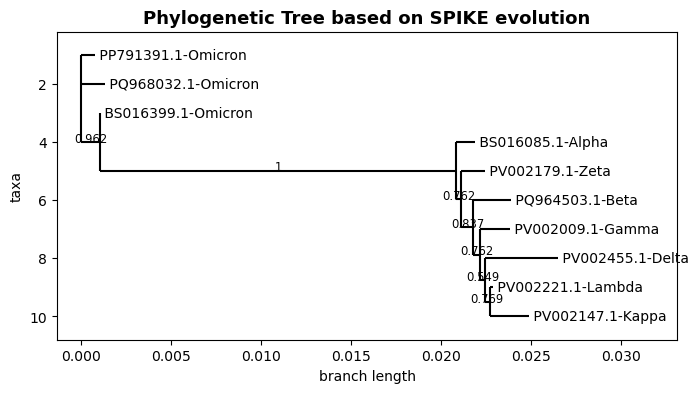

Phylo generation success!


In [116]:
tree_generation(file_name, protein='SPIKE')

## STEP 5

Create a Pipeline


In [31]:
def project_Pipeline(gene_file, genomes_file,low_inter, up_inter,myfile, protein, genomes_names):
    gene_seq=getGene(gene_file, low_inter, up_inter)
    genomes_ids=readGenomes(genomes_file)
    genomes=getGenomes(genomes_ids)
    getGenomes_names(genomes, genomes_names)
    geneInGenomes=findGene(gene_seq,genomes, protein)
    file_name=fileName(myfile)
    local_msa(geneInGenomes, genomes, file_name)
    tree_generation(file_name, protein)

### **PIPELINE's** arguments:

- **"gene_file"** *(str)*--> entire name of the csv file where we have saved the NCBI'ID of the genome of our interest. Remember that the function used retrieve only a piece of the genome, that should be the gene, defined by the "up_inter" and "low_inter" boundaries.
- **"genomes_file"** *(str)* --> entire name of the file where we have stored the NCBI' IDs of the genomes where we want to search the gene.
- **"low_inter"** *(int)*--> position within the genome where our gene's sequence stops (end index).
- **"up_inter"** *(int)*--> position within the genome where our gene's sequence starts (start index).
- **"myfile"** *(str)* --> basename of the file where we want to store the results of our analyses.
- **"protein"** *(str)* --> name of the protein codified by the gene we are searching within the genomes.
- **"genomes_names"** *(list[str])* --> list containing the names of the genomes' variants; It can be used for general renaming purposes.

# **SPIKE**

Check if the pipeline for the **spike** protein works

Reading from file success!
Gene uploading success!
Genomes uploading success!
Genomes named correctly!
"PP791391.1-Omicron" genome, found between: 20800 - 25021 of length: 4221
found a gene of length: 3545
"PQ968032.1-Omicron" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3806
"BS016399.1-Omicron" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3809
"BS016085.1-Alpha" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3812
"PV002179.1-Zeta" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3821
"PQ964503.1-Beta" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3812
"PV002009.1-Gamma" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3821
"PV002455.1-Delta" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3815
"PV002221.1-Lambda" genome, found between: 21300 - 25521 of length: 4221
found a gene

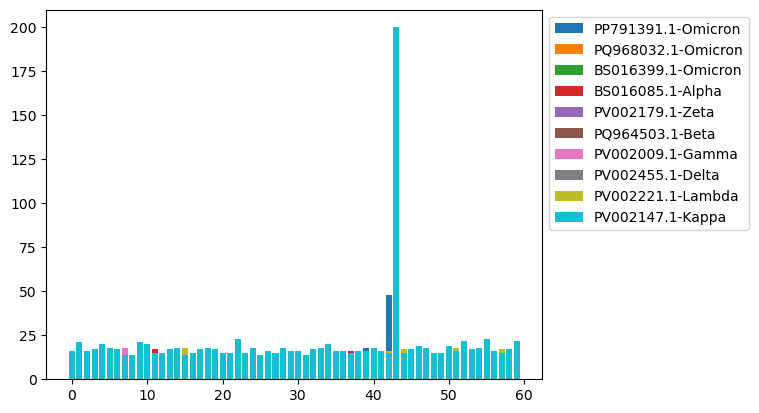

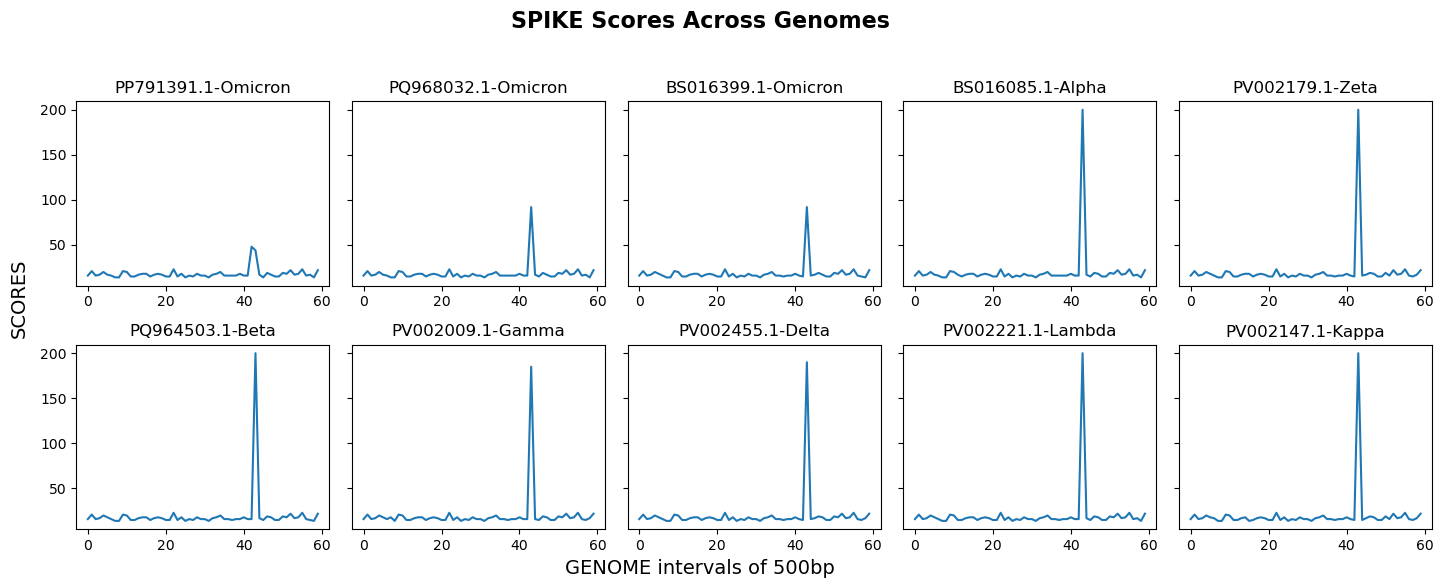

ClustalW (msa) success!


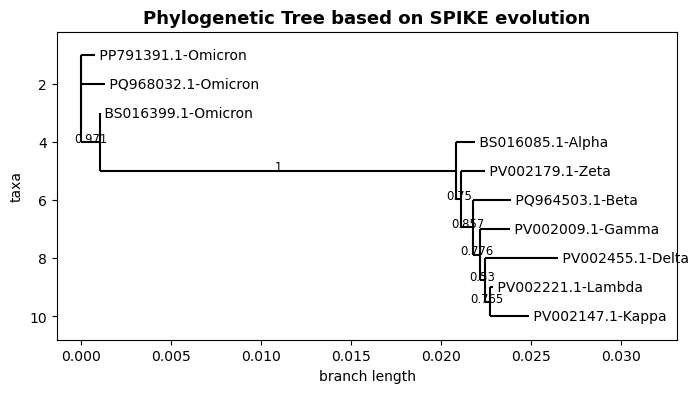

Phylo generation success!


In [122]:
project_Pipeline('SARS-CoV-2_genome.csv', 'SARS-CoV-2_variants.csv',21563,25384, 'local_spike', 'SPIKE',
                genomes_names=['Omicron', 'Omicron', 'Omicron', 'Alpha', 'Zeta', 'Beta', 'Gamma', 'Delta', 'Lambda', 'Kappa'])

# **NUCLEOCAPSID**

Check if the pipeline for the **Nucleocapsid** protein works.

Notice that we have only modified:
- **"low_inter"** and **"up_inter"** --> for defining the position of the gene
- **"myfile"** --> for storing the results in a different file
- **"protein"** --> for indicating that we are working on a different protein

Reading from file success!
Gene uploading success!
Genomes uploading success!
Genomes named correctly!
"PP791391.1-Omicron" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1250
"PQ968032.1-Omicron" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1250
"BS016399.1-Omicron" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1238
"BS016085.1-Alpha" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1258
"PV002179.1-Zeta" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1228
"PQ964503.1-Beta" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1247
"PV002009.1-Gamma" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1234
"PV002455.1-Delta" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1236
"PV002221.1-Lambda" genome, found between: 27800 - 29459 of length: 1659
found a gene

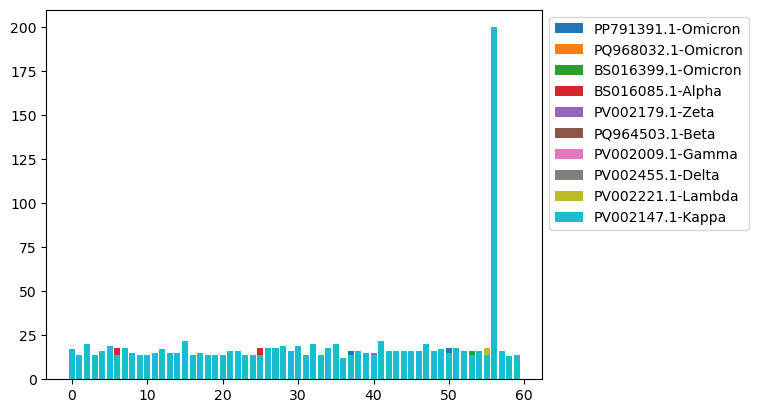

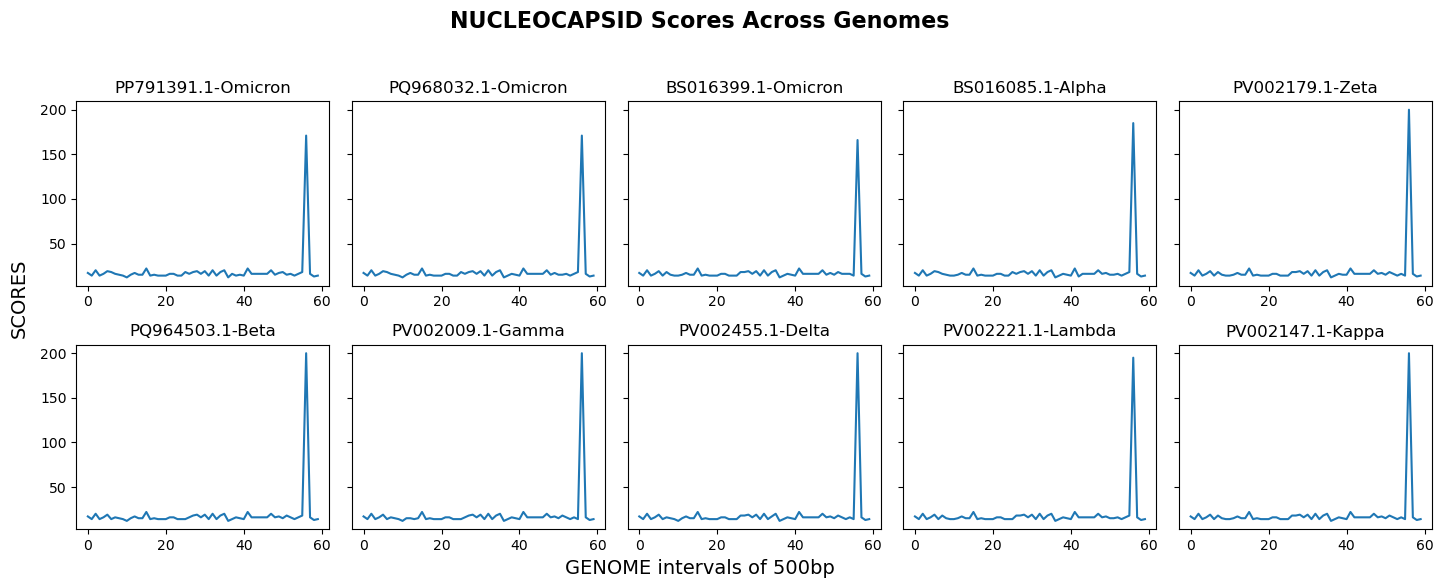

ClustalW (msa) success!


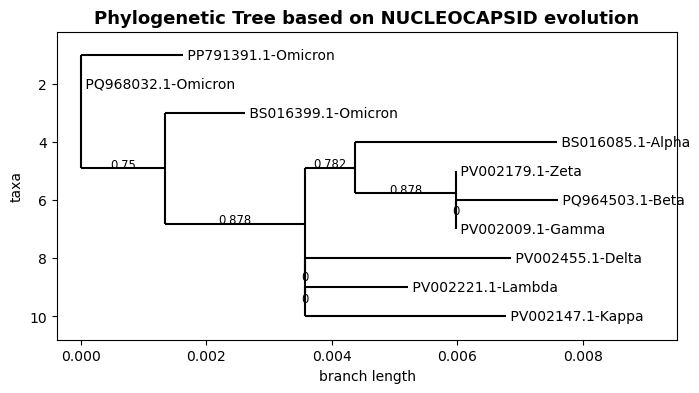

Phylo generation success!


In [125]:
project_Pipeline('SARS-CoV-2_genome.csv', 'SARS-CoV-2_variants.csv',28274,29533, 'local_N','NUCLEOCAPSID', 
                 genomes_names=['Omicron', 'Omicron', 'Omicron', 'Alpha', 'Zeta', 'Beta', 'Gamma', 'Delta', 'Lambda', 'Kappa'])